In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Games import *
from os import listdir
from os.path import join
from json import load

In [3]:
def plot(playthrough_data, filename):
    max_x = 23 # fix this
    max_y = 23 # fix this
    data = [[0 for _ in range(max_x)] for __ in range(max_y)]
    
    for run in playthrough_data:
        for segment, _ in run:
            if '__' in segment:
                continue
                
            a, b, _ = segment.split(',')
            data[int(a)][int(b)] += 1
            
    ax = sns.heatmap(data)
    ax.invert_yaxis()
    ax.set_title(filename)
    plt.show()

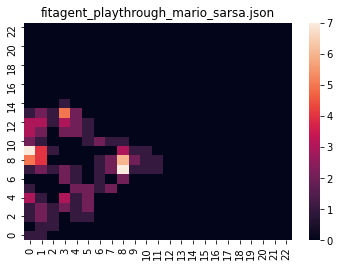

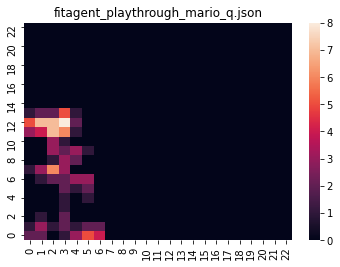

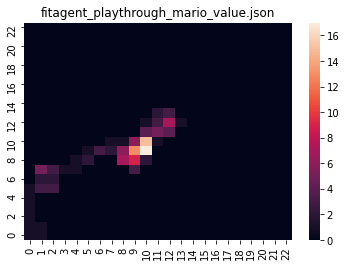

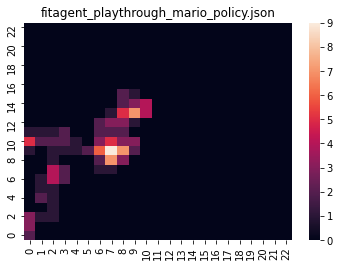

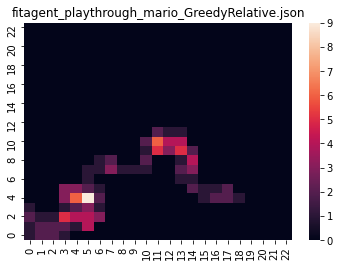

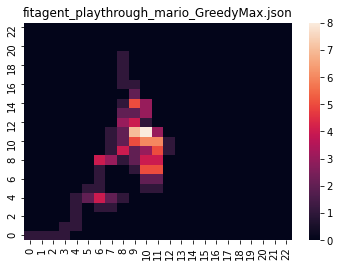

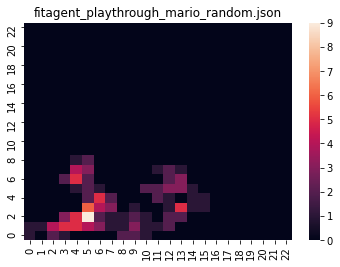

In [4]:
for filename in listdir(Mario.BASE_DIR):
    if 'fitagent_playthrough_' not in filename:
        continue
        
    with open(join(Mario.BASE_DIR, filename), 'r') as f:
        data = load(f)
        
    plot(data, filename)

In [5]:
ax = sns.heatmap(uniform_data)

NameError: name 'uniform_data' is not defined